In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

byte_pattern = re.compile('\\$[0-9A-F]{2,8}')

In [2]:
NUM_TRACKS = 16

In [3]:
with open('../smgp.asm') as f:
    lines = f.readlines()

In [4]:
# Build track dict

track_data_offset = next(i for i, line in enumerate(lines) if line.startswith('Track_data'))+1
tracks = dict()

for i in range(NUM_TRACKS):
    track = lines[track_data_offset + i*20:track_data_offset + i*20 + 19]
    name = track[0][2:].strip()
    tracks[name] = [t.strip() for t in track[1:]]

tracks.keys()

dict_keys(['San Marino', 'Brazil', 'France', 'Hungary', 'West Germany', 'USA', 'Canada', 'Great Britain', 'Italy', 'Portugal', 'Spain', 'Mexico', 'Japan', 'Belgium', 'Australia', 'Monaco'])

In [5]:
def extract_track_data(data_name, track):
    for line in track:
        if data_name in line:
            if '\t' in line:
                line = line[line.index('\t')+1:]
            if ';' in line:
                line = line[:line.index(';')]
            return line.strip()
    return None

In [6]:
def extract_loc_data(loc):
    loc_found = False
    byte_list = []

    for line in lines:
        if line.startswith(loc):
            loc_found = True
        elif loc_found:
            if line.startswith('loc'): # end of target_loc
                break
            byte_list += byte_pattern.findall(line)
    return byte_list

In [7]:
def parse_signed_byte(s):
    x = int(s[1:], 16)
    if x > 2**7-1:
        x = x - 2**8
    return x

def parse_signed_word(high, low):
    x = int(high[1:]+low[1:], 16)
    if x > 2**15-1:
        x = x - 2**16
    return x

def parse_curveslope_byte(s):
    b = int(s[1:], 16)
    if b == 0:
        return 0
    slope = (b & 0x3F)-0x30
    if b & 0x40:
        slope = -slope
    return slope

In [8]:
def parse_slope_data(slope):
    slope = slope.copy()
    slope.reverse() # Reverse so pop() gets from start
    slope.pop() # ignore initial vertical background displacement
    
    rle = [] # run length encoding tuples
    
    while slope:
        b1 = slope.pop()
        if b1 == '$FF':
            break
        b2 = slope.pop()
        b3 = slope.pop()
        if b3 != '$00':
            slope.pop() # ignore initial vertical background displacement
        length = parse_signed_word(b1, b2)
        value = parse_curveslope_byte(b3)
        rle += [(length, value)]
        
    return rle

In [9]:
def rle_decode(rles):
    for rle in rles:
        for n in range(rle[0]):
            yield rle[1]

In [10]:
def render_slope_data(track_data):
    slope_data_loc = extract_track_data('slope data', track_data)
    slope_data = extract_loc_data(slope_data_loc)
    slope_derivative = np.cumsum(list(rle_decode(parse_slope_data(slope_data))))
    return np.cumsum(slope_derivative)

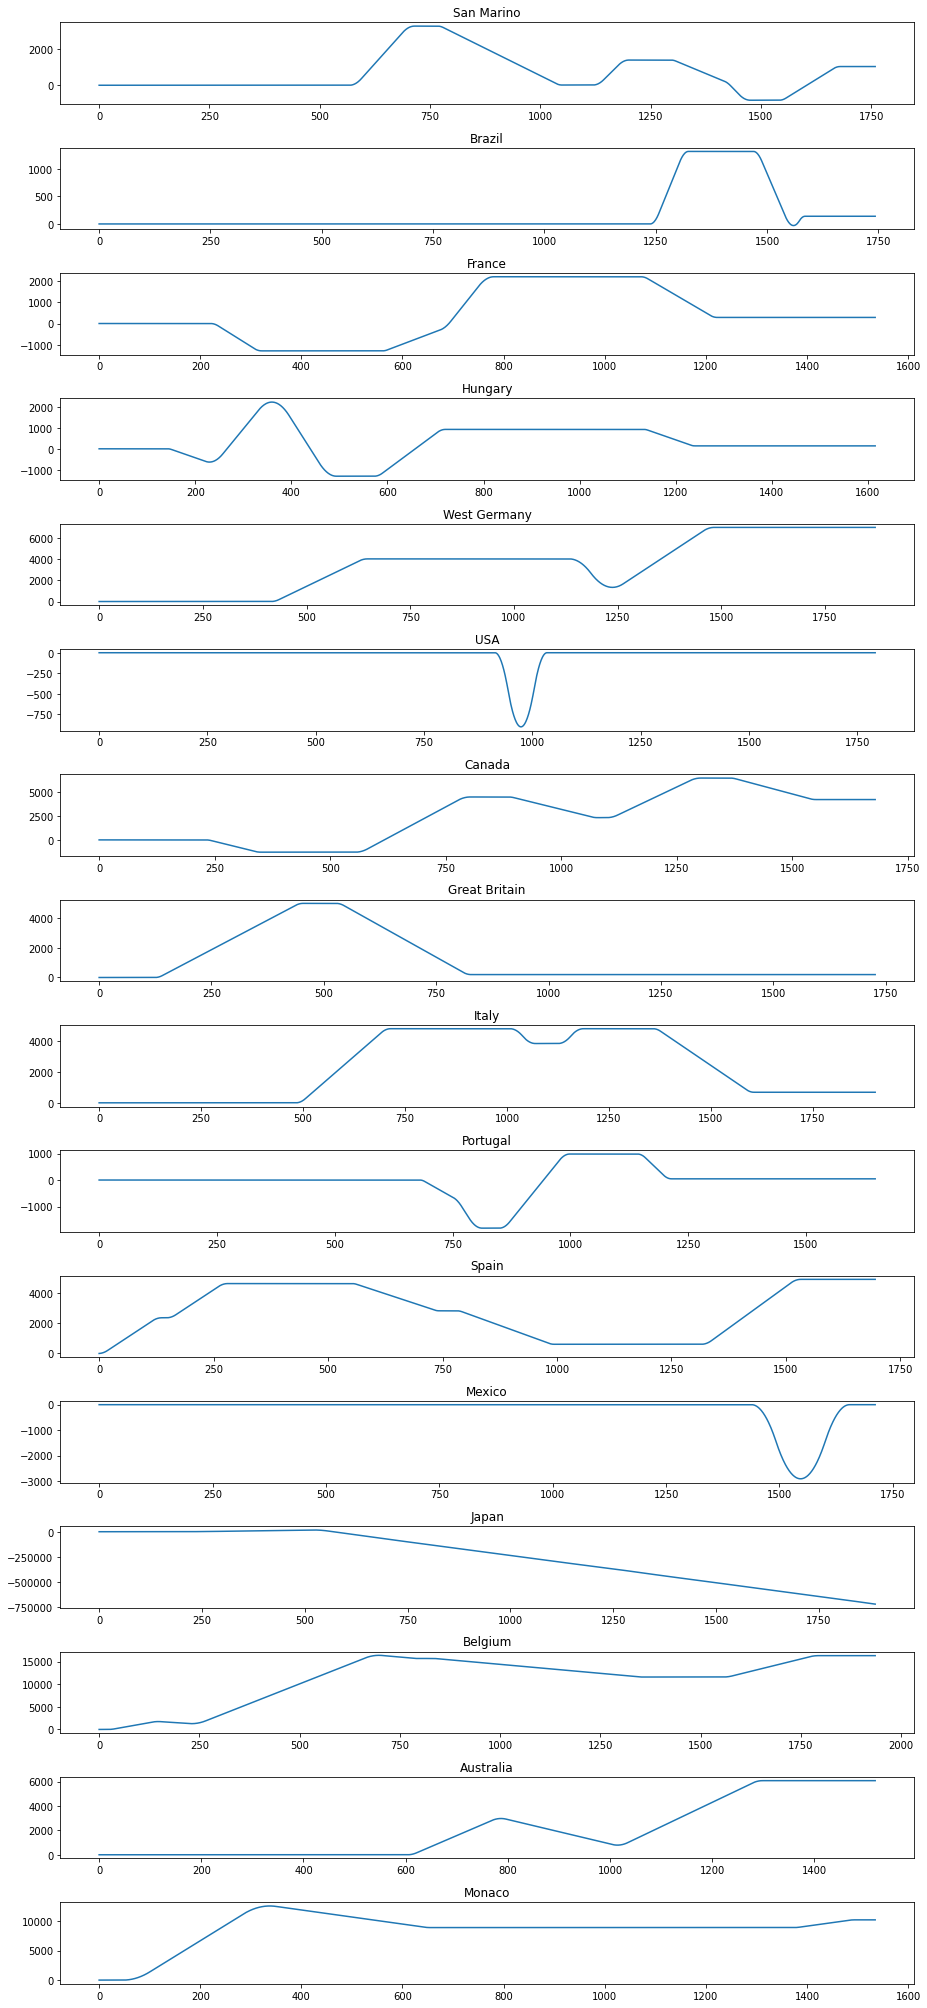

In [11]:
fig, ax = plt.subplots(NUM_TRACKS, 1, figsize=(13,28))

i=0
for name, track_data in tracks.items():
    ax[i].plot(render_slope_data(track_data))
    ax[i].set_title(name)
    i+=1

plt.tight_layout()
plt.show()